# 데모

## 라이브러리 import 및 설정

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import optuna.integration.lightgbm as lgb
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [6]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [7]:
data_dir = Path('./data/')


trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 10
n_class = 3
seed = 42

In [8]:
algo_name = 'lgb_optuna'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = data_dir / f'{feature_name}.csv'
p_val_file = data_dir / f'{model_name}.val.csv'
p_tst_file = data_dir / f'{model_name}.tst.csv'
sub_file = data_dir / f'{model_name}.csv'

In [9]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 25)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_zi,d_dered_zr,d_dered_zg,d_dered_zu,d_dered_ir,d_dered_ig,d_dered_iu,d_dered_ru,d_dered_gu,d_obs_det
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-0.7232,-2.0462,-3.3488,-6.2153,-1.3230,-2.6257,-5.4921,-4.1691,-2.8665,6.1132
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.1016,-0.2767,-0.8698,-1.8317,-0.1751,-0.7683,-1.7302,-1.5550,-0.9619,1.4427
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.0257,-0.1440,-0.3905,-1.3116,-0.1183,-0.3649,-1.2859,-1.1676,-0.9211,1.8205
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-0.2395,-0.5321,-1.4395,-5.7985,-0.2926,-1.2000,-5.5590,-5.2664,-4.3590,1.8640
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-0.3144,-0.9871,-2.5579,-5.8955,-0.6727,-2.2436,-5.5811,-4.9084,-3.3376,4.5471


In [10]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 24) (80000, 24)


## Hyperparameter Tuning

In [11]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.3, random_state=seed)

In [12]:
params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "max_depth" : 30,
    "num_class": 3,
    "n_estimators": 16000,
    "subsample_freq": 1,
    "lambda_l1": 0.,
    "lambda_l2": 0.,
    "random_state": seed,
    "n_jobs": -1,
}

In [13]:
dtrain = lgb.Dataset(X_trn, label=y_trn)
dval = lgb.Dataset(X_val, label=y_val)

model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dval], 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

prediction = np.argmax(model.predict(X_val, num_iteration=model.best_iteration), 
                       axis=1)
accuracy = accuracy_score(y_val, prediction)

params = model.params
print("Best params:", params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in params.items():
    print("    {}: {}".format(key, value))

[I 2020-10-08 20:47:32,166] A new study created in memory with name: no-name-328c31ea-c283-47f3-8f76-9610f836755f
feature_fraction, val_score: inf:   0%|                                                                                                                                                                             | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5804
[LightGBM] [Info] Number of data points in the train set: 224000, number of used features: 24
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Start training from score -0.980377
[LightGBM] [Info] Start training from score -2.010849
[LightGBM] [Info] Start training from score -0.711402
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.144495	valid_1's multi_logloss: 0.164085
Early stopping, best iteration is:
[87]	training's multi_logloss: 0.146941	valid_1's multi_logloss: 0.

feature_fraction, val_score: 0.162730:  14%|######################8                                                                                                                                         | 1/7 [00:12<01:16, 12.72s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5804
[LightGBM] [Info] Number of data points in the train set: 224000, number of used features: 24
[LightGBM] [Info] Start training from score -0.980377
[LightGBM] [Info] Start training from score -2.010849
[LightGBM] [Info] Start training from score -0.711402
Training until validation scores do

feature_fraction, val_score: 0.159466:  29%|#############################################7                                                                                                                  | 2/7 [00:25<01:03, 12.75s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5804
[LightGBM] [Info] Number of data points in the train set: 224000, number of used features: 24
[LightGBM] [Info] Start training from score -0.980377
[LightGBM] [Info] Start training from score -2.010849
[LightGBM] [Info] Start training from score -0.711402
Training until validation scores do

feature_fraction, val_score: 0.159466:  43%|####################################################################5                                                                                           | 3/7 [00:38<00:50, 12.67s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5804
[LightGBM] [Info] Number of data points in the train set: 224000, number of used features: 24
[LightGBM] [Info] Start training from score -0.980377
[LightGBM] [Info] Start training from score -2.010849
[LightGBM] [Info] Start training from score -0.711402
Training until validation scores do

feature_fraction, val_score: 0.159466:  57%|###########################################################################################4                                                                    | 4/7 [00:51<00:38, 12.82s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5804
[LightGBM] [Info] Number of data points in the train set: 224000, number of used features: 24
[LightGBM] [Info] Start training from score -0.980377
[LightGBM] [Info] Start training from score -2.010849
[LightGBM] [Info] Start training from score -0.711402
Training until validation scores do

feature_fraction, val_score: 0.159466:  71%|##################################################################################################################2                                             | 5/7 [01:07<00:27, 13.77s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5804
[LightGBM] [Info] Number of data points in the train set: 224000, number of used features: 24
[LightGBM] [Info] Start training from score -0.980377
[LightGBM] [Info] Start training from score -2.010849
[LightGBM] [Info] Start training from score -0.711402
Training until validation scores do

feature_fraction, val_score: 0.159466:  86%|#########################################################################################################################################1                      | 6/7 [01:14<00:11, 11.81s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5804
[LightGBM] [Info] Number of data points in the train set: 224000, number of used features: 24
[LightGBM] [Info] Start training from score -0.980377
[LightGBM] [Info] Start training from score -2.010849
[LightGBM] [Info] Start training from score -0.711402
Training until validation scores do

num_leaves, val_score: 0.159466:   0%|                                                                                                                                                                             | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


[W 2020-10-08 20:49:03,680] Trial 7 failed because of the following error: LightGBMError('Check failed: (num_leaves) <= (131072) at D:\\a\\1\\s\\python-package\\compile\\src\\io\\config_auto.cpp, line 319 .\n')
Traceback (most recent call last):
  File "c:\users\82102\appdata\local\programs\python\python37\lib\site-packages\optuna\study.py", line 799, in _run_trial
    result = func(trial)
  File "c:\users\82102\appdata\local\programs\python\python37\lib\site-packages\optuna\integration\_lightgbm_tuner\optimize.py", line 236, in __call__
    booster = lgb.train(self.lgbm_params, self.train_set, **self.lgbm_kwargs)
  File "c:\users\82102\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py", line 173, in train
    train_set._update_params(params) \
  File "c:\users\82102\appdata\local\programs\python\python37\lib\site-packages\lightgbm\basic.py", line 1436, in _update_params
    raise LightGBMError(decode_string(_LIB.LGBM_GetLastError()))
lightgbm.basic.LightGBMEr

LightGBMError: Check failed: (num_leaves) <= (131072) at D:\a\1\s\python-package\compile\src\io\config_auto.cpp, line 319 .


## Stratified K-Fold Cross Validation

In [13]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## LightGBM 모델 학습

In [14]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.00016468883762015717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016468883762015717
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.43499179721398096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43499179721398096
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 0.848612
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.743166
[3]	valid_0's multi_logloss: 0.656242
[4]	valid_0's multi_logloss: 0.587709
[5]	valid_0's multi_logloss: 0.533443
[6]	valid_0's multi_logloss: 0.485747
[7]	valid_0's multi_logloss: 0.448572
[8]	valid_0's multi_l

[159]	valid_0's multi_logloss: 0.155686
[160]	valid_0's multi_logloss: 0.155736
[161]	valid_0's multi_logloss: 0.155771
[162]	valid_0's multi_logloss: 0.155769
[163]	valid_0's multi_logloss: 0.155763
[164]	valid_0's multi_logloss: 0.155777
[165]	valid_0's multi_logloss: 0.155798
[166]	valid_0's multi_logloss: 0.155843
[167]	valid_0's multi_logloss: 0.155906
[168]	valid_0's multi_logloss: 0.155911
[169]	valid_0's multi_logloss: 0.155933
[170]	valid_0's multi_logloss: 0.155956
[171]	valid_0's multi_logloss: 0.155978
[172]	valid_0's multi_logloss: 0.156054
[173]	valid_0's multi_logloss: 0.156082
[174]	valid_0's multi_logloss: 0.156077
[175]	valid_0's multi_logloss: 0.156076
[176]	valid_0's multi_logloss: 0.156088
[177]	valid_0's multi_logloss: 0.156121
[178]	valid_0's multi_logloss: 0.156163
[179]	valid_0's multi_logloss: 0.156211
[180]	valid_0's multi_logloss: 0.156199
[181]	valid_0's multi_logloss: 0.156244
[182]	valid_0's multi_logloss: 0.156275
[183]	valid_0's multi_logloss: 0.15632
[

[105]	valid_0's multi_logloss: 0.158386
[106]	valid_0's multi_logloss: 0.158331
[107]	valid_0's multi_logloss: 0.158384
[108]	valid_0's multi_logloss: 0.158378
[109]	valid_0's multi_logloss: 0.158422
[110]	valid_0's multi_logloss: 0.158445
[111]	valid_0's multi_logloss: 0.158444
[112]	valid_0's multi_logloss: 0.158472
[113]	valid_0's multi_logloss: 0.158473
[114]	valid_0's multi_logloss: 0.158447
[115]	valid_0's multi_logloss: 0.158429
[116]	valid_0's multi_logloss: 0.1584
[117]	valid_0's multi_logloss: 0.158419
[118]	valid_0's multi_logloss: 0.158455
[119]	valid_0's multi_logloss: 0.158477
[120]	valid_0's multi_logloss: 0.158497
[121]	valid_0's multi_logloss: 0.158496
[122]	valid_0's multi_logloss: 0.158512
[123]	valid_0's multi_logloss: 0.158525
[124]	valid_0's multi_logloss: 0.158514
[125]	valid_0's multi_logloss: 0.158504
[126]	valid_0's multi_logloss: 0.158549
[127]	valid_0's multi_logloss: 0.158633
[128]	valid_0's multi_logloss: 0.15863
[129]	valid_0's multi_logloss: 0.158691
[13

[82]	valid_0's multi_logloss: 0.159137
[83]	valid_0's multi_logloss: 0.159095
[84]	valid_0's multi_logloss: 0.159042
[85]	valid_0's multi_logloss: 0.158971
[86]	valid_0's multi_logloss: 0.158924
[87]	valid_0's multi_logloss: 0.158881
[88]	valid_0's multi_logloss: 0.158822
[89]	valid_0's multi_logloss: 0.158806
[90]	valid_0's multi_logloss: 0.158775
[91]	valid_0's multi_logloss: 0.158739
[92]	valid_0's multi_logloss: 0.158715
[93]	valid_0's multi_logloss: 0.158717
[94]	valid_0's multi_logloss: 0.158658
[95]	valid_0's multi_logloss: 0.158627
[96]	valid_0's multi_logloss: 0.158642
[97]	valid_0's multi_logloss: 0.158649
[98]	valid_0's multi_logloss: 0.158661
[99]	valid_0's multi_logloss: 0.15871
[100]	valid_0's multi_logloss: 0.158703
[101]	valid_0's multi_logloss: 0.15869
[102]	valid_0's multi_logloss: 0.158706
[103]	valid_0's multi_logloss: 0.158705
[104]	valid_0's multi_logloss: 0.158683
[105]	valid_0's multi_logloss: 0.158682
[106]	valid_0's multi_logloss: 0.158671
[107]	valid_0's mult

[75]	valid_0's multi_logloss: 0.154537
[76]	valid_0's multi_logloss: 0.154372
[77]	valid_0's multi_logloss: 0.154303
[78]	valid_0's multi_logloss: 0.154233
[79]	valid_0's multi_logloss: 0.15419
[80]	valid_0's multi_logloss: 0.154116
[81]	valid_0's multi_logloss: 0.154108
[82]	valid_0's multi_logloss: 0.154051
[83]	valid_0's multi_logloss: 0.15397
[84]	valid_0's multi_logloss: 0.153912
[85]	valid_0's multi_logloss: 0.153815
[86]	valid_0's multi_logloss: 0.153788
[87]	valid_0's multi_logloss: 0.153752
[88]	valid_0's multi_logloss: 0.15369
[89]	valid_0's multi_logloss: 0.153662
[90]	valid_0's multi_logloss: 0.153658
[91]	valid_0's multi_logloss: 0.153642
[92]	valid_0's multi_logloss: 0.153622
[93]	valid_0's multi_logloss: 0.153636
[94]	valid_0's multi_logloss: 0.153568
[95]	valid_0's multi_logloss: 0.153556
[96]	valid_0's multi_logloss: 0.15355
[97]	valid_0's multi_logloss: 0.153562
[98]	valid_0's multi_logloss: 0.15351
[99]	valid_0's multi_logloss: 0.153485
[100]	valid_0's multi_logloss:

[18]	valid_0's multi_logloss: 0.237574
[19]	valid_0's multi_logloss: 0.228644
[20]	valid_0's multi_logloss: 0.22071
[21]	valid_0's multi_logloss: 0.213475
[22]	valid_0's multi_logloss: 0.206837
[23]	valid_0's multi_logloss: 0.201162
[24]	valid_0's multi_logloss: 0.196864
[25]	valid_0's multi_logloss: 0.192919
[26]	valid_0's multi_logloss: 0.188677
[27]	valid_0's multi_logloss: 0.185075
[28]	valid_0's multi_logloss: 0.181895
[29]	valid_0's multi_logloss: 0.17915
[30]	valid_0's multi_logloss: 0.176536
[31]	valid_0's multi_logloss: 0.174521
[32]	valid_0's multi_logloss: 0.172812
[33]	valid_0's multi_logloss: 0.171642
[34]	valid_0's multi_logloss: 0.170112
[35]	valid_0's multi_logloss: 0.168802
[36]	valid_0's multi_logloss: 0.167441
[37]	valid_0's multi_logloss: 0.166627
[38]	valid_0's multi_logloss: 0.165493
[39]	valid_0's multi_logloss: 0.164458
[40]	valid_0's multi_logloss: 0.163662
[41]	valid_0's multi_logloss: 0.162711
[42]	valid_0's multi_logloss: 0.161676
[43]	valid_0's multi_loglos

[201]	valid_0's multi_logloss: 0.15725
Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 0.155797


In [1]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

NameError: name 'accuracy_score' is not defined

In [16]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [17]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

<AxesSubplot:ylabel='feature'>

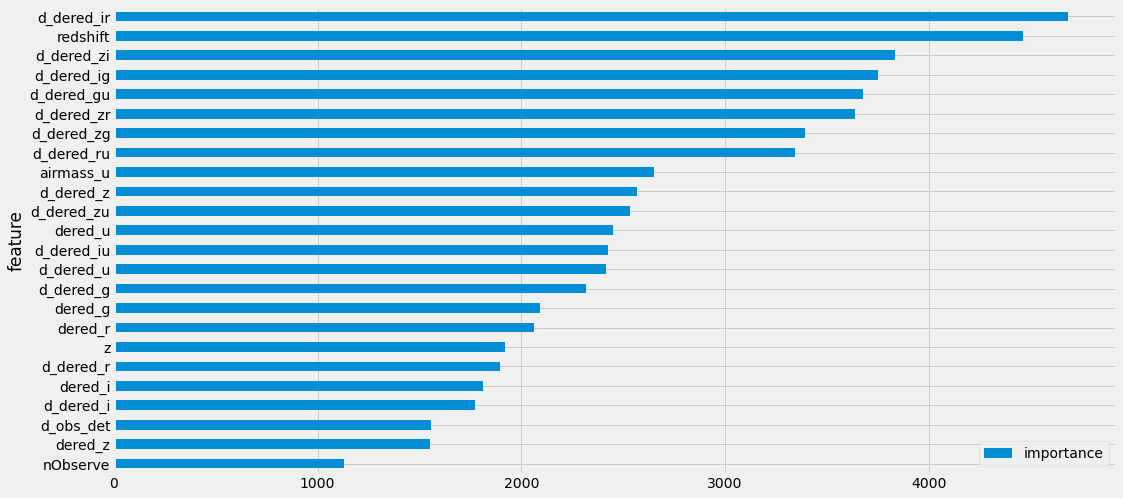

In [18]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [19]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [20]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [21]:
sub[target_col].value_counts()

2    40743
0    29974
1     9283
Name: class, dtype: int64

In [22]:
sub.to_csv(sub_file)